# 1次元移流方程式（スペクトル法）

## 準備

In [1]:
using PyPlot
using OffsetArrays  # 配列の添え字を自由にする
using FFTW

## 次元

In [2]:
imax = 100
dx = 1.0
dt = 0.1
c = 1.0
x = range( 0, (imax-1)*dx, step=dx )
imax2 = imax ÷ 2 + 1

51

## 初期条件

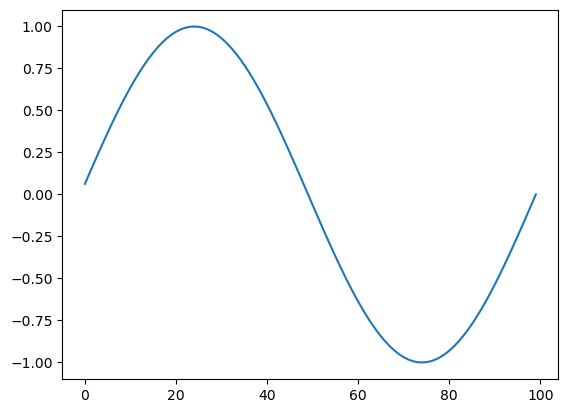

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\thisi\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007C19CAF0>

In [3]:
u = zeros(Float64,imax)
#=
for i in 1:length(u)
    if i >= imax/2-imax/10 && i < imax/2+imax/10
        u[i] = 1.0
    end
end
=#
for i in 1:length(u)
    u[i] = sin(i*2pi/imax)
    #u[i] = 5
end
u
plot(x,u)

fft(u)、およびifft(U)は以下の計算を行う：
$$
  U(X_k) = \Sigma_{n=1}^{imax} \exp \left( -i \frac{2 \pi (n-1)(k-1)}{imax} u(x_n) \right) \\
  u(x_n) = \frac{1}{imax} \Sigma_{k=1}^{imax} \exp \left( i \frac{2 \pi (n-1)(k-1)}{imax} U(X_k) \right)
$$

In [4]:
#U=fft(u)
U=rfft(u)

51-element Vector{ComplexF64}:
 -2.1510571102112408e-15 + 0.0im
      3.1395259764656633 - 49.901336421413575im
    8.18864985967178e-16 - 2.4372202656561336e-15im
    7.98436684012554e-16 - 3.2295582601579074e-15im
  2.1407163535689815e-15 - 1.1358825446769892e-15im
   2.897122701870303e-15 - 3.172741111322042e-16im
 -2.1215766354369318e-15 - 1.0097261065629392e-15im
   1.811911907532015e-15 + 2.501710947661107e-16im
   -3.67604872184741e-16 + 9.116227974966843e-16im
  -4.143070038345714e-15 - 2.0722034433471453e-15im
 -1.8291396019358348e-16 + 7.302930226507188e-16im
  4.0575262628105104e-15 + 1.6901807186509235e-15im
  2.9853167645421453e-16 + 3.627845677755655e-16im
                         ⋮
  -7.494043524951346e-16 + 3.729443679625756e-15im
   4.689338259019218e-16 - 4.869166680521349e-16im
    5.41194436242336e-16 - 3.3759836779752463e-15im
  -4.948932541583638e-16 + 1.1411569396121569e-15im
  2.4418567581366537e-16 - 2.803515214338215e-15im
    4.39961366944637e-16 + 7.02395021

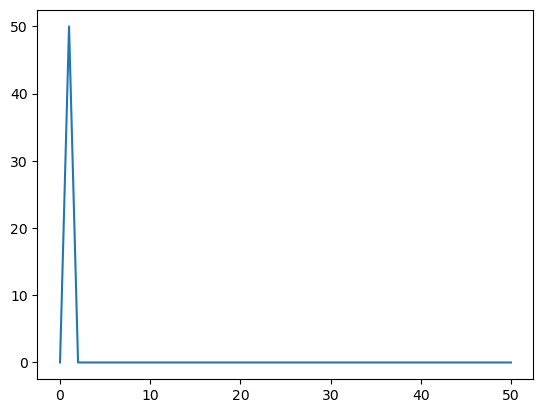

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007FF2C520>

In [5]:
plot(x[1:imax2],abs.(U))
#U[3:imax2] .= 0.0
#U[1] = 0.0

## 支配方程式

$$
  \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$
フーリエ変換後の変数を大文字で表すと、
$$
  \frac{d U}{d t} + i k c U = 0
$$
となる。この常微分方程式が支配方程式である。

## 前進オイラー法
$n$ステップ目の値を $U(t_{n})$ とする。
$$
  U(t_{n+1}) = U(t_{n}+\Delta t) = U(t_{n}) + \Delta t \left( \frac{d U}{d t} \right)_{t=t_{n}} + O((\Delta t)^2) \\
  \frac{U(t_{n+1}) - U(t_{n})}{\Delta t} = \left( \frac{d U}{d t} \right)_{t=t_{n}} + O((\Delta t)^1)
$$
$t=t_{n}$ における支配方程式に代入すると、
$$
\frac{U(t_{n+1}) - U(t_{n})}{\Delta t} = -i k c U(t_{n}) + O((\Delta t)^1)
$$
導関数を $O((\Delta t)^1)$ の誤差で近似することになるので、この差分式は1次精度である。$O((\Delta t)^1) \to 0$ とすると、
$$
      U(t_{n+1}) = \left( 1 - i k c \Delta t \right) U(t_{n})
$$
が得られる。従って、
$$
      U(t_{n}) = \left( 1 - i k c \Delta t \right)^n U(t_0)
$$
が直ちに得られ、$\Delta t = t_n / n$ に注意すると、
$$
      \lim_{\Delta t \to 0} U(t_{n}) = \lim_{n \to \infty} \left( 1 - \frac{i k c t_n}{n} \right)^n U(t_0) = U(t_0) e^{-i k c t_n}
$$
これは支配方程式の解そのものである。つまり、前進オイラー法によって得られた解は $\Delta t \to 0$ の時、元の支配方程式の解に収束する。但し、
$$
      \left| \frac{U(t_{n+1})}{U(t_{n})} \right| = \left| 1 - i k c \Delta t \right| = 1 + \left( k c \Delta t \right)^2
$$
なので、数値解は不安定である。

In [6]:
# 前進オイラー法
function OneStepAdvance!(U)
    dU = Array{ComplexF64}(undef,imax2)
    for k in 1:length(U)
    #for k in 1:50
        dU[k] = -im * (k-1) * c * U[k] * dt * ( 2 * pi / imax)  # k → k ( 2 * pi / imax) とする根拠は？
    end
    U = U + dU
    return U
end

OneStepAdvance! (generic function with 1 method)

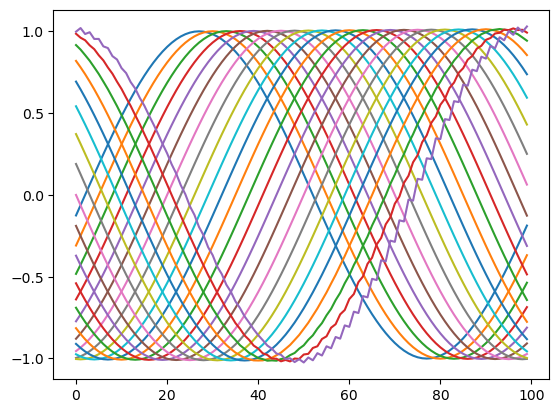

In [7]:

#u = real(ifft(U))
#u = irfft(U,imax)
#plot(x,u)

#U = OneStepAdvance!(U)
#u = irfft(U,imax)
#plot(x,u)

for t in 1:750
#for t in 1:300
#for t in 1:3
#for t in 1:30
    U = OneStepAdvance!(U)
    if rem(t,30) == 0
        #plot(x,abs.(U))
        u = irfft(U,imax)
        plot(x,u)
    end
end

#println( u )